In [1]:
import os
import math
# Essential Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
# Algorithms
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, r2_score
import sqlite3
from datetime import datetime
import matplotlib.dates as mdates


In [2]:
def requete_sql (requete) :
    try:
        connexion = sqlite3.connect('./data/liste_piezos.db')
        curseur = connexion.cursor()
        print("Connexion réussie à SQLite")
        curseur.execute(requete)
        connexion.commit()
        resultat = curseur.fetchall()
        curseur.close()
        connexion.close()
        print("Connexion SQLite est fermée")
        return resultat
    except sqlite3.Error as error:
        print("Erreur lors du mis à jour dans la table", error)

# Import des données
## Sélection des piezos

Récupération des codes_bss par jointure de tables dans la base de données

In [3]:
region = "PAC"

In [4]:
requete = f"""
        SELECT code_bss
        FROM data_piezo
        INNER JOIN code_region
            ON code_dpt = departement
        WHERE code_region IS '{region}'
        AND fichier_piezo IS 1
         """
data = requete_sql(requete)
code_bss = []
for code in data:
    code_bss.append(code[0]) 

Connexion réussie à SQLite
Connexion SQLite est fermée


In [5]:
code_bss

['09145X0057_N210',
 '09406X0643_P130',
 '09145X0059_N340',
 '09735X0070_P40',
 '08472X0007_F-1',
 '09662X0038_F41',
 '09141X0092_N381',
 '09411X0235_PC1',
 '10462X0117_F1',
 '09988X0069_F1',
 '09993X0229_PZ_L1',
 '09441X0013_P1',
 '10212X0029_P1',
 '08466X0021_S1',
 '09143X0128_PT1',
 '09964X0020_PZ1',
 '08688X0023_PZ1',
 '09951X0065_P12',
 '09954X0146_F2',
 '08466X0009_F2',
 '10202X0117_PN2',
 '09724X0023_P2',
 '09675X0123_P2',
 '08466X0022_S2',
 '09692X0128_PZ-3',
 '09665X0073_203',
 '09724X0034_P53',
 '09951X0068_F3',
 '10447X0195_P3',
 '08466X0023_S3',
 '09445X0008_PZ-4',
 '09664X0207_F44',
 '09146X0240_N184',
 '08466X0024_S4',
 '09728X0032_P15',
 '10475X0083_MGR15',
 '09994X0399_P-35',
 '09402X0244_P185',
 '10453X0295_P4795',
 '09663X0260_PA5',
 '08465X0019_S5',
 '09668X0106_16',
 '09994X0191_P16',
 '09994X0400_P-36',
 '09145X0058_N256',
 '08465X0020_S6',
 '09724X0028_P37',
 '09728X0151_P57',
 '09407X0392_156038',
 '09728X0099_P38',
 '09407X0393_P259',
 '09728X0168_PZS10A',
 '099

## Construction d'un dataframe

In [6]:
directory = './data/piezo/'

# Lecture des données du premier piezo de la liste pour initialiser le dataframe
data = pd.read_csv(directory+f"{code_bss[0]}.csv", sep=";",  index_col=0, parse_dates=True)
data.rename(columns={"piezo":f"{code_bss[0]}"}, inplace=True)

custom_date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")

for file in code_bss[1:]:
    df = pd.read_csv(f"{directory+file}.csv", sep=";",  index_col=0, parse_dates=True, date_parser=custom_date_parser)
    df.rename(columns={"piezo":f"{file}"}, inplace=True)
    data = pd.merge(data,df,left_index=True, right_index=True,how='outer')

In [30]:
data

,09145X0057_N210,09406X0643_P130,09145X0059_N340,09735X0070_P40,08472X0007_F-1,09662X0038_F41,09141X0092_N381,09411X0235_PC1,10462X0117_F1,09988X0069_F1,...,10443X0301_PIEZ,09692X0122_PIEZ,09433X0162_PIEZ,09952X0093_PIEZ,09695X0205_PIEZ,09675X0115_PIEZ,10446X0267_PIEZ,10475X0098_PIEZ,10195X0041_PZ,09924X0114_PZ
date_mesure,,,,,,,,,,,,,,,,,,,,,
1954-10-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1954-10-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1954-10-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1954-10-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1954-11-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-26,-3.45,-3.75,NaN,NaN,-3.75,-4.67,-4.28,NaN,-89.00,-21.24,...,-17.17,-8.13,-5.59,-4.41,-14.15,NaN,-10.67,-3.88,-2.50,-5.52
2022-05-27,-3.43,-3.75,NaN,NaN,-3.77,-4.66,-4.29,NaN,-89.00,-21.31,...,-17.14,-8.14,-5.58,-4.38,-14.15,NaN,-10.67,-3.89,-2.51,-5.53
2022-05-28,-3.42,-3.75,NaN,NaN,-3.78,-4.66,NaN,NaN,-88.99,-21.35,...,-17.11,-8.15,-5.59,-4.35,-14.15,NaN,-10.67,-3.89,-2.50,-5.54


## Visualisation des valeurs manquantes

In [31]:
# Fonction d'affichage des valeurs manquantes
def f_plot_nan (dataframe):
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,6))
    sns.heatmap(dataframe.T.isna(), cmap='Blues', cbar=False)
    ax.set_title('Missing Values', fontsize=16)
    # Masquage des noms de piezo 
    ax.yaxis.set_visible(False)
    # Formatage de la date pour l'affichage
    ax.xaxis.set_ticklabels([pd.to_datetime(value).strftime('%Y') for value in ax.xaxis.get_major_formatter().func.args[0].values()])
    plt.show()

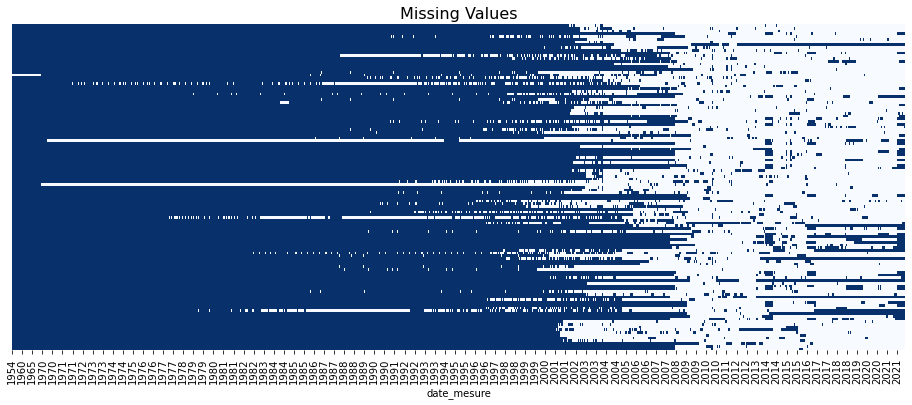

In [32]:
f_plot_nan(data)

# Traitement des données

## Rééchantillonnage à la semaine

In [33]:
data_week = pd.DataFrame(data.resample('7D').mean())

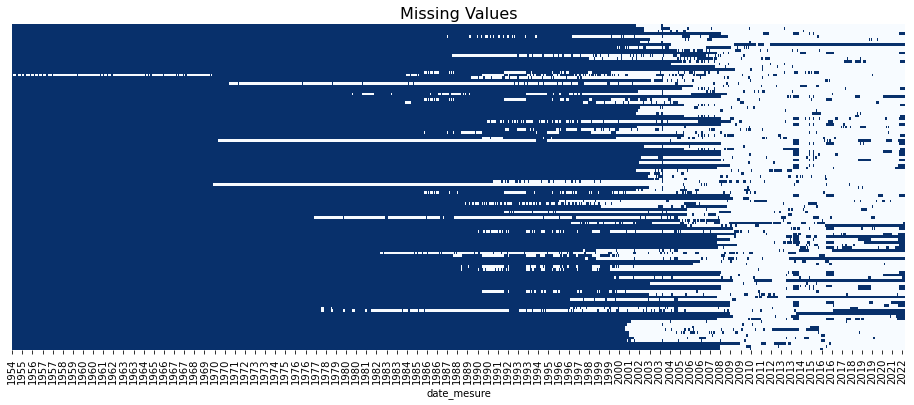

In [34]:
f_plot_nan(data_week)

In [35]:
data_week.shape

(3530, 119)

## Echelle de temps fixée après 2009 pour limiter les Nan

In [36]:
data_week_from_ = data_week.loc['01-01-2009':]

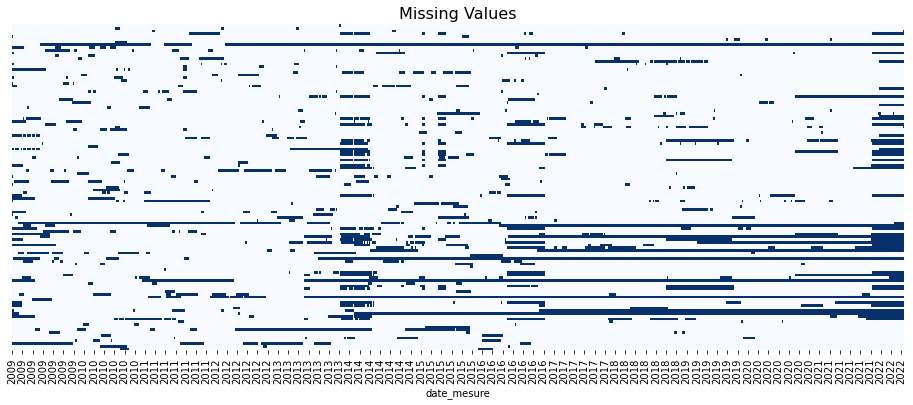

In [37]:
f_plot_nan(data_week_from_)

In [38]:
data_week_from_.shape

(699, 119)

## Suppression des valeurs abbérantes
Utilisation de la méthode IQR pour supprimer les valeurs abbérantes.
- Calcul des quartiles et de l'écart interquartile
- Suppression des valeurs < Q1 - 1.5*IQR
- Suppression des valeurs > Q3 + 1.5*IQR

In [39]:
nbre_na = data_week_from_.isna().sum().sum()
print(f"Il y a à ce stade {nbre_na} valeurs nulles dans l'ensemble du dataframe.")

Il y a à ce stade 10254 valeurs nulles dans l'ensemble du dataframe.


In [40]:
data_wo_outliers = data_week_from_.copy()

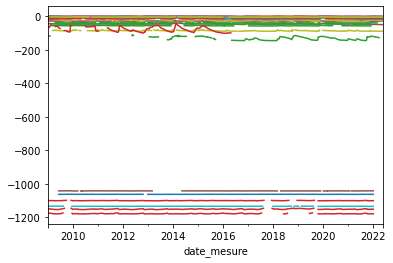

In [41]:
for piezo in data_wo_outliers.columns : 
    q1 = np.nanquantile(data_wo_outliers[f"{piezo}"], .25)
    q3 = np.nanquantile(data_wo_outliers[f"{piezo}"], .75)
    IQR = q3-q1
    data_wo_outliers.loc[data_wo_outliers[f"{piezo}"] < (q1-1.5*IQR), piezo] = np.NaN
    data_wo_outliers.loc[data_wo_outliers[f"{piezo}"] > (q3+1.5*IQR), piezo] = np.NaN
    data_wo_outliers[f"{piezo}"].plot()

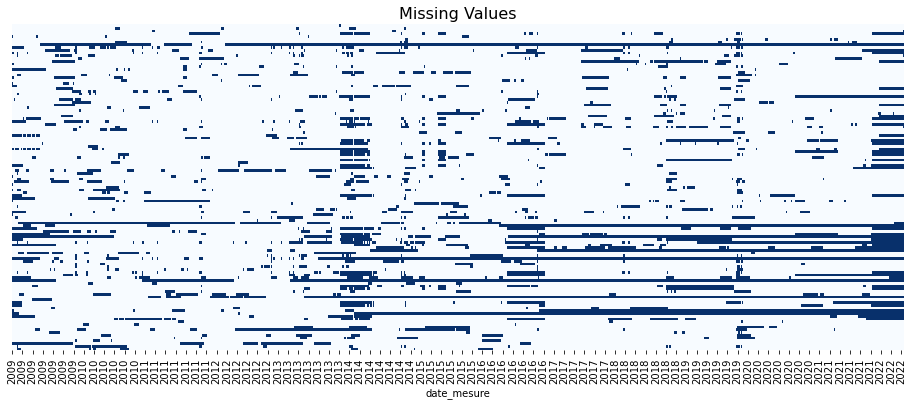

In [42]:
f_plot_nan(data_wo_outliers)

In [43]:
nbre_na_2 = data_wo_outliers.isna().sum().sum()
print(f"Il y a à ce stade {nbre_na_2} valeurs nulles dans l'ensemble du dataframe.")

Il y a à ce stade 11888 valeurs nulles dans l'ensemble du dataframe.


## Suppression des piezos avec plus de 10% de valeurs manquantes

In [49]:
# Liste des piezos avec plus de 10% de valeurs manquantes
bss_to_drop = data.loc[:,data_wo_outliers.isna().sum()>0.10*data_wo_outliers.shape[0]].columns

In [50]:
data_clean = data_wo_outliers.copy().drop(bss_to_drop, axis=1)

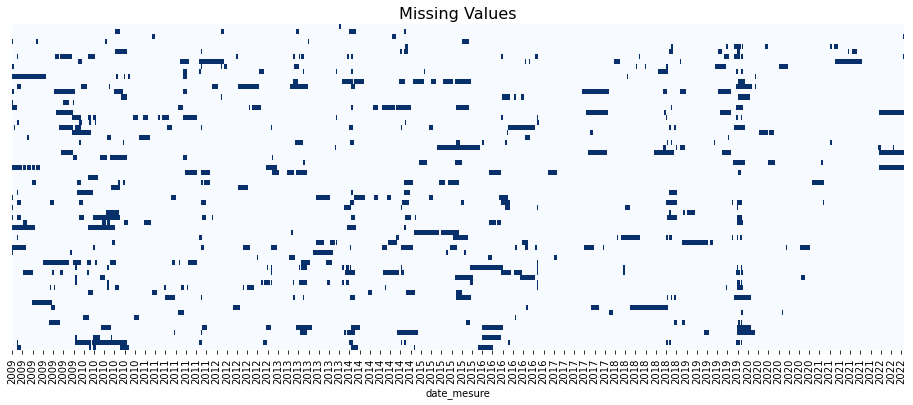

In [51]:
f_plot_nan(data_clean)

In [52]:
nbre_na_3 = data_clean.isna().sum().sum()
print(f"Il y a à ce stade {nbre_na_3} valeurs nulles dans l'ensemble du dataframe.")

Il y a à ce stade 2274 valeurs nulles dans l'ensemble du dataframe.


In [53]:
data_clean.shape

(699, 65)

## Interpolation

In [54]:
data_interpol = data_clean.copy().interpolate('linear')

In [55]:
data_interpol.shape

(699, 65)

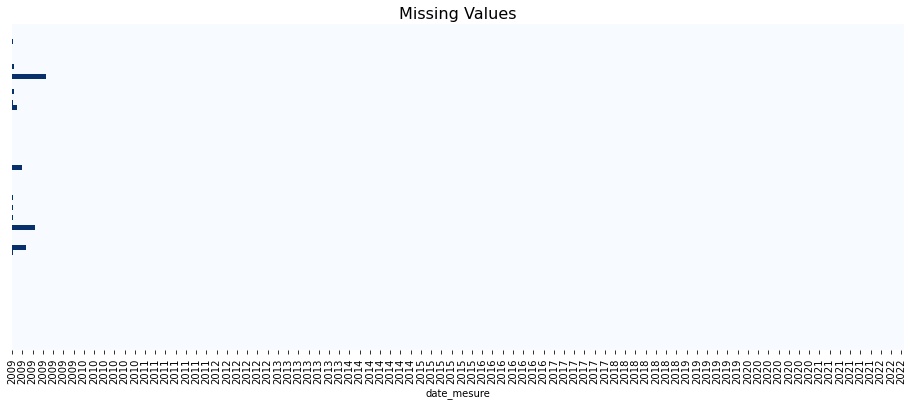

In [56]:
f_plot_nan(data_interpol)

## Réajustement des dates de début et de fin

In [57]:
debut = []
for column in data_interpol.columns:
    debut.append(data_interpol[f"{column}"].first_valid_index())
date_debut = max(debut)

In [58]:
fin = []
for column in data_interpol.columns:
    fin.append(data_interpol[f"{column}"].last_valid_index())
date_fin = min(fin)
date_fin

Timestamp('2022-05-24 00:00:00', freq='7D')

In [59]:
data_interpol = data_interpol.loc[date_debut:date_fin]

In [60]:
print(f"Nombre total de Nan : {data_interpol.isna().sum().sum()}")

Nombre total de Nan : 0


In [61]:
data_interpol.shape

(672, 65)

In [62]:
data_interpol.shape[1]

65

## Affichage des chroniques après nettoyage

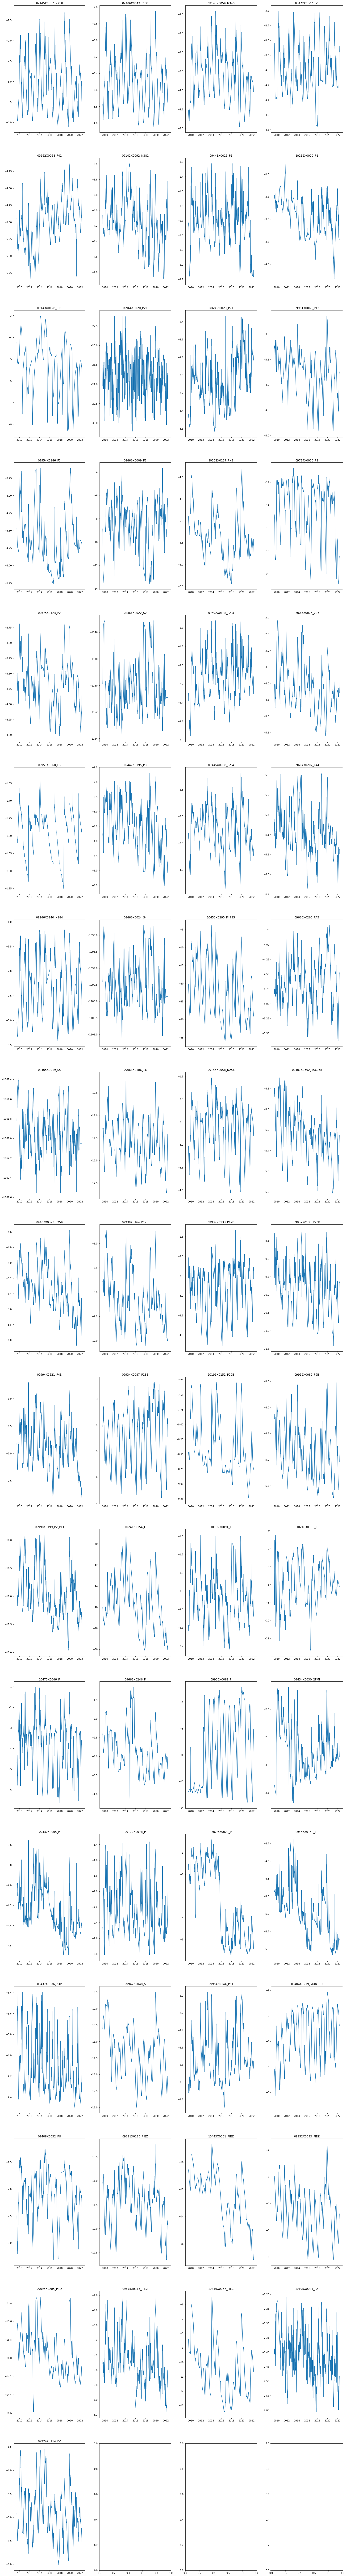

In [63]:
if data_interpol.shape[1]%4 == 0:
    nbre_lignes = data_interpol.shape[1]//4
else : 
    nbre_lignes = data_interpol.shape[1]//4 + 1

fig, axs = plt.subplots(nbre_lignes,4,figsize=(25,200))
#fig.suptitle('Series')
for i in range(nbre_lignes):
    for j in range(4):
        if i*4+j+1>data_interpol.shape[1]: # pass the others that we can't fill
            continue
        axs[i, j].plot(data_interpol.iloc[:,i*4+j])
        axs[i, j].set_title(data_interpol.columns[i*4+j])
plt.show()

## Normalisation StandardScaler

In [64]:
def scaleColumns(df):
    for col in df.columns:
        df[col] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df[col])),columns=[col], index=df.index)
    return df

In [65]:
scaler = StandardScaler()
data_norm = scaleColumns(data_interpol.copy())

In [66]:
data_norm.head()

,09145X0057_N210,09406X0643_P130,09145X0059_N340,08472X0007_F-1,09662X0038_F41,09141X0092_N381,09441X0013_P1,10212X0029_P1,09143X0128_PT1,09964X0020_PZ1,...,09404X0219_MONTEU,09408X0052_PU,09691X0120_PIEZ,10443X0301_PIEZ,09952X0093_PIEZ,09695X0205_PIEZ,09675X0115_PIEZ,10446X0267_PIEZ,10195X0041_PZ,09924X0114_PZ
date_mesure,,,,,,,,,,,,,,,,,,,,,
2009-07-14,-0.841163,-0.928906,-1.527569,1.230570,0.159012,0.309955,-0.042377,1.017959,0.919222,-0.550235,...,-1.349827,-0.844115,0.845828,1.029215,1.531772,1.305217,-0.105905,1.126515,0.215136,-0.028553
2009-07-21,-0.951878,-1.042145,-1.685369,0.921842,0.124935,0.097692,-0.148300,1.135223,0.776183,0.295410,...,-1.435445,-1.255639,0.932688,0.984163,1.435227,1.228903,-0.056305,1.011796,0.053981,-0.200555
2009-07-28,-1.113339,-1.268622,-1.786644,0.681216,0.022706,-0.054583,-0.165954,0.967703,0.577853,0.085938,...,-1.521063,-1.754457,1.034524,0.942218,1.367809,1.199551,0.033876,0.902578,-0.017643,-0.396746
2009-08-04,-1.242507,-1.339396,-1.878498,0.449669,-0.147678,0.023862,-0.236570,0.954301,0.410774,0.404025,...,-1.606680,-2.278215,1.091433,0.888622,1.300391,1.181940,-0.132960,0.799645,0.197230,-0.557998
2009-08-11,-1.367062,-1.452635,-2.024522,0.140941,-0.501223,-0.169943,-0.898591,0.930848,0.220858,0.344545,...,-1.692298,-2.175334,1.109404,0.830365,1.232974,1.322828,-0.123942,0.691998,0.179324,-0.713875


## Sauvegarde du dataframe en csv

In [67]:
data_norm.to_csv(f"./data/piezo_clustering/{region}.csv", sep = ";")